# Explore LCDS as function of Alpha and of K
## First set up plotting in notebook
## Then import packages for the data & empirical models

In [1]:
import matplotlib.pyplot as plt
import spacepy.plot as splot
%matplotlib inline

import spacepy.time as spt
import spacepy.empiricals as emp
import spacepy.omni as om
import spacepy.LANLstar as lns

### First, set timestamps at 30min cadence for Sept 24th dropout event

In [2]:
tt = spt.tickrange('2013-09-22T00:00:00','2013-09-27T00:00:00',0.5/24) #half hourly resolution

mp = emp.ShueMP(tt, dbase='qd1min') #the 'qd1min' keyword needs to be set in spacepy.rc
                                    #and should specify where the 1-min QinDenton files are

Key ExtModel for conversion not found in file
Variable OriginFile appears to be non-record varying, skipping interpolation


### Now we have our timestamps and the Shue magnetopause stand-off location, get LCDS from LANL* NN

In [3]:
omdata = om.get_omni(tt, dbase='qd1min') #qd1min needs to be set in spacepy.rc file

Key ExtModel for conversion not found in file
Variable OriginFile appears to be non-record varying, skipping interpolation


In [4]:
omdata['DOY'] = tt.DOY
omdata['Hr'] = omdata['Hour']
omdata['PA'] = [90]*len(tt)
lcds = lns.LANLmax(omdata, ['T05'])

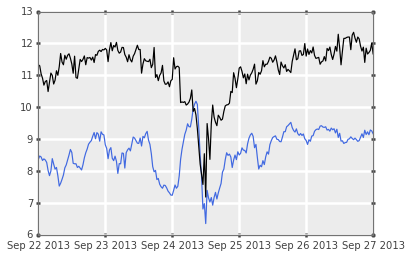

In [5]:
plt.plot(tt.UTC, lcds['T05'])
plt.plot(tt.UTC, mp, 'k-')

### Does this vary as a function of pitch angle?

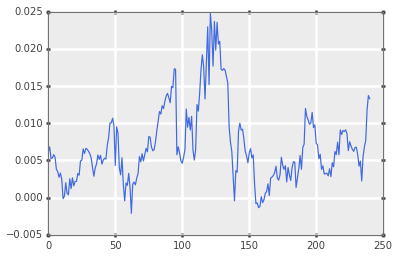

In [6]:
omdata['PA'] = [40]*len(tt) #40 degrees equatorial pitch angle
lcds40 = lns.LANLmax(omdata, ['T05'])
plt.plot(lcds['T05']-lcds40['T05'])

### Yes, but only very little... let's see that for 90, 65, 40 and 15

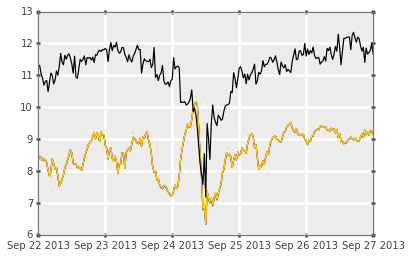

In [7]:
omdata['PA'] = [65]*len(tt)
lcds65 = lns.LANLmax(omdata, ['T05'])
omdata['PA'] = [15]*len(tt)
lcds15 = lns.LANLmax(omdata, ['T05'])
plt.plot(tt.UTC, lcds15['T05'])
plt.plot(tt.UTC, lcds40['T05'])
plt.plot(tt.UTC, lcds65['T05'])
plt.plot(tt.UTC, lcds['T05'])
plt.plot(tt.UTC, mp, 'k-')

So the differences are negligible...
Let's just find the maximum difference between a couple of these.

In [8]:
print((lcds['T05']-lcds15['T05']).max())
print((lcds['T05']-lcds15['T05']).min())

0.0375918668733
-0.00239455900337


## Now the slow part - finding LCDS as a function of K using IRBEM
### This can be done through SpacePy; for LANLGeoMag we need to just read the output files

In [9]:
import spacepy.irbempy as ib
import spacepy.coordinates as spc
import spacepy.datamodel as dm

recalc_irb = True #set to False if you just want to use the extant file

In [38]:
tt2 = spt.tickrange('2013-09-23T00:00:00','2013-09-25T12:00:00', 1.0/24) #hourly res, to be quicker
omdata2 = om.get_omni(tt2) #don't use qd1min dbase for now... needs variable renaming, etc.

#separate G and W parameters into G1, G2, etc.
for dim in omdata2['G'].shape[1]:
    dim_labl = 'G{0}'.format(dim+1)
    omdata2[dim_labl] = omdata2['G'][:,dim]
for dim in omdata2['W'].shape[1]:
    dim_labl = 'W{0}'.format(dim+1)
    omdata2[dim_labl] = omdata2['W'][:,dim]

#provide mapping from qd1min variable names to those expected by irbempy, only list those that need to change
keymap = {'dens': 'Den_P', 'velo': 'Vsw'}
#now for required keys, add them
for newkey in keymap.keys():
    omdata2[newkey] = omdata2[keymap[newkey]]

In [39]:
if recalc_irb is True: #this step will take forever...
    irb_tt = dm.dmcopy(tt2)
    irb_lcds = ib.find_LCDS_K(irb_tt, 0.2, extMag='T05', tol=0.1, omnivals=omdata2)
    dm.toJSONheadedASCII('irb_lcds.txt', irb_lcds)
else:
    irb_lcds = dm.readJSONheadedASCII('irb_lcds.txt', convert=True)

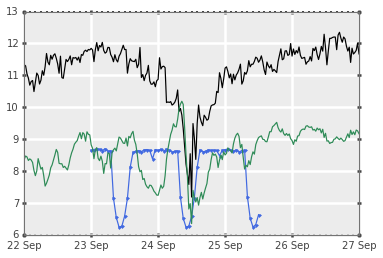

In [44]:
tt2 = spt.tickrange('2013-09-23T00:00:00','2013-09-25T12:00:00', 1.0/24)
plt.plot(tt2.UTC, irb_lcds['LCDS'], marker='.')
splot.applySmartTimeTicks(plt.gca(), tt.UTC)
plt.plot(tt.UTC, mp, 'k-')
plt.plot(tt.UTC, lcds['T05'])

### Now compare to LANLGeoMag output

Key ExtModel for conversion not found in file


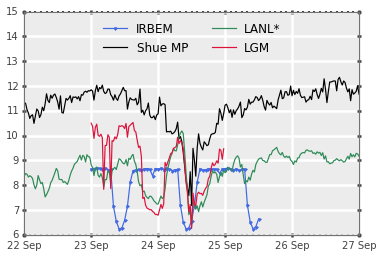

In [45]:
#get LGM output from file
lgm_lcds = dm.readJSONheadedASCII(['20130923_LCDS_TS04.txt','20130924_LCDS_TS04.txt'], convert=True)

#repeat plotting code but add line for LGM
plt.plot(tt2.UTC, irb_lcds['LCDS'], ls='-', marker='.', label='IRBEM')
splot.applySmartTimeTicks(plt.gca(), tt.UTC)
plt.plot(tt.UTC, mp, 'k-', label='Shue MP')
plt.plot(tt.UTC, lcds['T05'], label='LANL*')
plt.plot(lgm_lcds['DateTime'], lgm_lcds['LCDS'], label='LGM')
plt.ylim([6,15])
plt.legend(ncol=2, loc=9)